#####Università degli studi di Milano Bicocca.
#####Artificial Intelligence project.
#TWEC on language shift

##### Amrani Hamza
##### Carta Costantino
##### Vitali Simone



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Install twec library

In [0]:
import os

!git clone git://github.com/vinid/twec
%cd twec
!python setup.py install
!python -m spacy download it_core_news_sm
!python -m spacy download en_core_web_sm

os.kill(os.getpid(), 9)

In [0]:
from twec.twec import TWEC
from gensim.models.word2vec import Word2Vec

import csv
import warnings
warnings.filterwarnings('ignore')

## Download Europarl dataset

In [0]:
import os
import zipfile

!test -e it_en_txt.zip && echo "File exists" || wget http://opus.nlpl.eu/download.php?f=Europarl/v8/moses/en-it.txt.zip
!mv download.php?f=Europarl%2Fv8%2Fmoses%2Fen-it.txt.zip it_en_txt.zip

if not os.path.exists(('it_en_txt.zip').strip('.zip')):
    zipfile.ZipFile('it_en_txt.zip').extractall()

--2020-02-18 21:07:32--  http://opus.nlpl.eu/download.php?f=Europarl/v8/moses/en-it.txt.zip
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-Europarl/v8/moses/en-it.txt.zip [following]
--2020-02-18 21:07:33--  https://object.pouta.csc.fi/OPUS-Europarl/v8/moses/en-it.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210242995 (201M) [application/zip]
Saving to: ‘download.php?f=Europarl%2Fv8%2Fmoses%2Fen-it.txt.zip’

download.php?f=Euro 100%[===================>] 200.50M  19.3MB/s    in 11s     

2020-02-18 21:07:46 (17.6 MB/s) - ‘download.php?f=Europarl%2Fv8%2Fmoses%2Fen-it.txt.zip’ saved [210242995/210242995]



## Preprocessing

In [0]:
import collections
from collections import Counter
import gensim
import spacy
from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer 
import nltk
import random

In [0]:
# Union of token lists in different lnguage in one unique list

def union_of_list(diff_lang_list):
  print("union_of_list function")
  print(diff_lang_list[0][:10])
  print(len(diff_lang_list[0]))
  print(len(diff_lang_list[1]))

  x = diff_lang_list[0]
  for word_list in diff_lang_list[1]:
    x.append(word_list)

  print(len(x))
  print(x[0])
  return x

In [0]:
# Remove words with occurence <= 3
def remove_word(sentence_list):
  print("remove_word function")
  counts = Counter([item for sublist in sentence_list for item in sublist])
  print(counts.most_common(30))
  tot_del = 0
  for i, sentence in enumerate(sentence_list):
    for j, word in enumerate(sentence):
      if counts[word] <= 3:
        del sentence_list[i][j]
        tot_del = tot_del + 1
  print("Total Deleted Words: ", tot_del)
  return sentence_list

In [0]:
nltk.download('stopwords')
#nltk.download('wordnet')
from gensim.models.phrases import Phrases, Phraser

# Init the Wordnet Lemmatizer
#lemmatizer = WordNetLemmatizer()
nlp_it = spacy.load('it_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')

# subsampling indexes
random.seed( 30 )
indexes = list(range(0, 1946253))
random_indexes = random.sample(indexes, 500000)

#def further_preprocessing(token_list, language):

def remove_stop_words(token_list, language):
  print("remove_stop_words function")
  stop_words = set(stopwords.words(language))
  tokens = []
  for token in token_list:
    tokens.append([word for word in token if not word in stop_words])
  print(tokens[85])
  return tokens

def lemmatization(tokens, language):
  print("lemmatization function")
  tokens_lemma = []
  for m, token in enumerate(tokens):
    if m % 10000 == 0:
      print(m)
    if language == 'english':
      lemmas = nlp_en(u" ".join(token))
    elif language == 'italian':
      lemmas = nlp_it(u" ".join(token))
    tokens_lemma.append([word.lemma_ for word in lemmas])
  print(tokens_lemma[85])
  return tokens_lemma


def read_data(file_names=[], lang_list=[]):
  print("read_data function")
  #Extract the first file enclosed in a zip file as a list of words
  data_list = []

  for i, filename in enumerate(file_names):
    with open(filename) as f:
      data = f.readlines()
      data = [x.strip() for x in data] 

      # # subsampling
      data = [data[x] for x in random_indexes ]
      # print(data[85])

      simple_prep = [gensim.utils.simple_preprocess(sentence, deacc=True, min_len=2) for sentence in data]
      remove_stopwords = remove_stop_words(simple_prep, lang_list[i])
      phrases = Phrases(remove_stopwords, min_count=1, threshold=1)
      phrases = list(phrases[remove_stopwords])
      print(phrases[85])
      lemming = lemmatization(phrases, lang_list[i])
      print(lemming[85])
      if len(file_names) == 1:
        return lemming
      data_list.append(lemming)
  return data_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
en_it_sentences = read_data(['Europarl.en-it.en', 'Europarl.en-it.it'], ['english', 'italian'])
copy_sentence = en_it_sentences.copy()
preprocess_sent = union_of_list(copy_sentence)
preprocess_sent = remove_word(preprocess_sent)

len_lang_sentences = int(len(preprocess_sent) / 2)
en_sentences = preprocess_sent[:len_lang_sentences]
del preprocess_sent[:len_lang_sentences]
it_sentences = preprocess_sent.copy()

In [0]:
print(len(en_sentences))
print(len(it_sentences))

print(en_sentences[85])
print(it_sentences[85])

sentences_en = [ item for elem in en_sentences for item in elem]
sentences_it = [ item for elem in it_sentences for item in elem]

print(len(set(sentences_en)))
print(len(set(sentences_it)))

In [0]:
# salvataggio in pickle di **_sentences
import pickle

with open('en_sentences', 'wb') as f:
  pickle.dump(en_sentences, f)

with open('it_sentences', 'wb') as f:
  pickle.dump(it_sentences, f)

In [0]:
# ************************************
# cariamento di pickle di **_sentences
import pickle

with open('en_sentences', 'rb') as f:
  en_sentences = pickle.load(f)

with open('it_sentences', 'rb') as f:
  it_sentences = pickle.load(f)

In [0]:
import pickle

with open('/content/drive/My Drive/ai_project/en_sentences', 'rb') as f:
  en_sentences = pickle.load(f)

with open('/content/drive/My Drive/ai_project/it_sentences', 'rb') as f:
  it_sentences = pickle.load(f)

In [0]:
en = [item for sublist in en_sentences for item in sublist]
en = set(en)
print(len(en))

it = [item for sublist in it_sentences for item in sublist]
it = set(it)
print(len(it))

23557
28650


In [0]:
# divisione training/testing
# per testing prendo le ultime n frasi per ciascuna lingua e le salvo su un file csv
n = 500

en_test = en_sentences[:n]
it_test = it_sentences[:n]

del en_sentences[:n]
del it_sentences[:n]

print(len(en_sentences))
print(len(it_sentences))

print(len(en_test))
print(len(it_test))

499500
499500
500
500


In [0]:
# salvataggio dei dizionari
with open('Europarl.en-it.en', 'w') as f:
    for item in en_sentences:
        f.write("%s\n" % ' '.join(item))
    f.close()

with open('Europarl.en-it.it', 'w') as f:
    for item in it_sentences:
        f.write("%s\n" % ' '.join(item))
    f.close()

# concatenazione dei due dizionari

def concatenate_files(filenames):
#filenames = ['file1.txt', 'file2.txt', ...]
  with open('concat_lang_file.en-it.en', 'w') as outfile:
      for fname in filenames:
          with open(fname) as infile:
              for line in infile:
                  line = line.lower()
                  outfile.write(line)

concatenate_files(['Europarl.en-it.en', 'Europarl.en-it.it'])

In [0]:
# salvataggio test
with open('en_test', 'wb') as f:
  pickle.dump(en_test, f)

with open('it_test', 'wb') as f:
  pickle.dump(it_test, f)
#print(it_test)

### Creazione testing - da modificare

In [0]:
from googletrans import Translator
import numpy as np
import itertools
import spacy
import collections


translator = Translator(service_urls=['translate.google.com','translate.google.co.kr', 
                                      'translate.google.at', 'translate.google.de',
                                      'translate.google.ru', 'translate.google.ch',
                                      'translate.google.fr', 'translate.google.es', 'translate.google.it'] )
nlp_it = spacy.load('it_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')


In [0]:
def lemmatize(word, language):
  if language == 'english':
    lemmas = nlp_en(word)
    print("Lemma : " + str([lemmaxxx.lemma_ for lemmaxxx in lemmas]))
    return [lemmaxxx.lemma_ for lemmaxxx in lemmas]
  elif language == 'italian':
    lemmas = nlp_it(word)
    print("Lemma : " + str([lemmaxxx.lemma_ for lemmaxxx in lemmas]))
    return [lemmaxxx.lemma_ for lemmaxxx in lemmas]


with open('en_test', 'rb') as f:
  en_test = pickle.load(f)
with open('it_test', 'rb') as f:
  it_test = pickle.load(f)

# flatten the list of lists
test_ita = list(set(itertools.chain(*it_test)))
test_eng = list(set(itertools.chain(*en_test)))


ita = [None] * len(test_eng)
eng = [None] * len(test_eng)
# From eng to ita
for i,word in enumerate(test_eng):
  print(str(i) + "\n\n")
  translation = translator.translate(word , dest="it", src="en") #translate to italian 
  lemmatization = lemmatize(translation.text, "italian")
  if(len(lemmatization) == 1):
    lemmatization = lemmatization[0].lower()
    boh = nlp_it(lemmatization)
    for t in boh:
      tag = t.pos_
    if(tag != "VERB"): 
      eng[i] = word
      ita[i] = lemmatization
      print("Original : " + eng[i] + ",   Translated : " + ita[i] + ", Tag : " + tag)

with open("Eng_to_Ita_TEST.txt", 'w') as f:
  for i in range(len(ita)):
    if(eng[i] != None and ita[i] != None):
      f.write(str(eng[i]) + "," + str(ita[i]) + "\n")
  f.close()


ita = [None] * len(test_ita)
eng = [None] * len(test_ita)
# from ita to eng
for i,word in enumerate(test_ita):
  translation = translator.translate(word , dest="en", src="it") #translate to italian   
  lemmatization = lemmatize(translation.text, "english")
  if(len(lemmatization) == 1) : 
    lemmatization = lemmatization[0].lower() 
    boh = nlp_en(lemmatization)
    for t in boh:
      tag = t.pos_
    if(tag != "VERB"): 
      ita[i] = word
      eng[i] = lemmatization
      print("Original : " + ita[i] + ",   Translated : " + eng[i] + ", Tag : " + tag)

with open("Ita_to_Eng_TEST.txt", 'w') as f:
  for i in range(len(ita)):
    if(eng[i] != None and ita[i] != None):
      f.write(str(ita[i]) + "," + str(eng[i]) + "\n")
  f.close()


## 1) TWEC AS-IS 

In [0]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Inizio TWEC e fa word2vec sull'unione dei due file
aligner = TWEC(size=300, siter=10, diter=10, workers=4)

# train the compass: the text should be the concatenation of the text from the slices
aligner.train_compass('concat_lang_file.en-it.en', overwrite=False) # keep an eye on the overwrite behaviour

2020-02-17 10:49:42,856 : INFO : files read into PathLineSentences:concat_lang_file.en-it.en
2020-02-17 10:49:42,864 : INFO : collecting all words and their counts
2020-02-17 10:49:42,865 : INFO : reading file concat_lang_file.en-it.en
2020-02-17 10:49:42,867 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-02-17 10:49:42,942 : INFO : PROGRESS: at sentence #10000, processed 130622 words, keeping 8877 word types
2020-02-17 10:49:43,012 : INFO : PROGRESS: at sentence #20000, processed 260974 words, keeping 11596 word types


Training the compass.


2020-02-17 10:49:43,098 : INFO : PROGRESS: at sentence #30000, processed 392484 words, keeping 13348 word types
2020-02-17 10:49:43,175 : INFO : PROGRESS: at sentence #40000, processed 522347 words, keeping 14663 word types
2020-02-17 10:49:43,254 : INFO : PROGRESS: at sentence #50000, processed 653181 words, keeping 15630 word types
2020-02-17 10:49:43,333 : INFO : PROGRESS: at sentence #60000, processed 783683 words, keeping 16442 word types
2020-02-17 10:49:43,411 : INFO : PROGRESS: at sentence #70000, processed 913620 words, keeping 17120 word types
2020-02-17 10:49:43,489 : INFO : PROGRESS: at sentence #80000, processed 1043468 words, keeping 17715 word types
2020-02-17 10:49:43,562 : INFO : PROGRESS: at sentence #90000, processed 1173893 words, keeping 18195 word types
2020-02-17 10:49:43,634 : INFO : PROGRESS: at sentence #100000, processed 1305729 words, keeping 18595 word types
2020-02-17 10:49:43,700 : INFO : PROGRESS: at sentence #110000, processed 1436769 words, keeping 189

In [0]:
# Train slices
#slice_en = Word2Vec.load("model/Europarl.en-it.model")

slice_en = aligner.train_slice('Europarl.en-it.en', save=True)
slice_ita = aligner.train_slice('Europarl.en-it.it', save=True)

2020-02-17 11:02:19,457 : INFO : collecting all words and their counts
2020-02-17 11:02:19,459 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-02-17 11:02:19,535 : INFO : PROGRESS: at sentence #10000, processed 130622 words, keeping 8877 word types
2020-02-17 11:02:19,605 : INFO : PROGRESS: at sentence #20000, processed 260974 words, keeping 11596 word types


Training temporal embeddings: slice Europarl.en-it.en.


2020-02-17 11:02:19,671 : INFO : PROGRESS: at sentence #30000, processed 392484 words, keeping 13348 word types
2020-02-17 11:02:19,739 : INFO : PROGRESS: at sentence #40000, processed 522347 words, keeping 14663 word types
2020-02-17 11:02:19,813 : INFO : PROGRESS: at sentence #50000, processed 653181 words, keeping 15630 word types
2020-02-17 11:02:19,885 : INFO : PROGRESS: at sentence #60000, processed 783683 words, keeping 16442 word types
2020-02-17 11:02:19,954 : INFO : PROGRESS: at sentence #70000, processed 913620 words, keeping 17120 word types
2020-02-17 11:02:20,024 : INFO : PROGRESS: at sentence #80000, processed 1043468 words, keeping 17715 word types
2020-02-17 11:02:20,092 : INFO : PROGRESS: at sentence #90000, processed 1173893 words, keeping 18195 word types
2020-02-17 11:02:20,158 : INFO : PROGRESS: at sentence #100000, processed 1305729 words, keeping 18595 word types
2020-02-17 11:02:20,225 : INFO : PROGRESS: at sentence #110000, processed 1436769 words, keeping 189

Initializing temporal embeddings from the atemporal compass.


2020-02-17 11:02:28,865 : INFO : training model with 4 workers on 19619 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=10 window=5
2020-02-17 11:02:29,883 : INFO : EPOCH 1 - PROGRESS: at 2.92% words, 177029 words/s, in_qsize 7, out_qsize 0
2020-02-17 11:02:30,958 : INFO : EPOCH 1 - PROGRESS: at 6.29% words, 184701 words/s, in_qsize 4, out_qsize 3
2020-02-17 11:02:31,964 : INFO : EPOCH 1 - PROGRESS: at 9.67% words, 191204 words/s, in_qsize 8, out_qsize 0
2020-02-17 11:02:32,973 : INFO : EPOCH 1 - PROGRESS: at 13.04% words, 194448 words/s, in_qsize 8, out_qsize 0
2020-02-17 11:02:34,007 : INFO : EPOCH 1 - PROGRESS: at 16.42% words, 195481 words/s, in_qsize 7, out_qsize 0
2020-02-17 11:02:35,075 : INFO : EPOCH 1 - PROGRESS: at 19.79% words, 195083 words/s, in_qsize 7, out_qsize 0
2020-02-17 11:02:36,386 : INFO : EPOCH 1 - PROGRESS: at 20.41% words, 166018 words/s, in_qsize 5, out_qsize 1
2020-02-17 11:02:37,424 : INFO : EPOCH 1 - PROGRESS: at 23.94% words, 171093 words

Training temporal embeddings: slice Europarl.en-it.it.


2020-02-17 11:07:36,008 : INFO : PROGRESS: at sentence #30000, processed 430773 words, keeping 15518 word types
2020-02-17 11:07:36,083 : INFO : PROGRESS: at sentence #40000, processed 573614 words, keeping 17080 word types
2020-02-17 11:07:36,162 : INFO : PROGRESS: at sentence #50000, processed 717606 words, keeping 18277 word types
2020-02-17 11:07:36,239 : INFO : PROGRESS: at sentence #60000, processed 860760 words, keeping 19286 word types
2020-02-17 11:07:36,321 : INFO : PROGRESS: at sentence #70000, processed 1003313 words, keeping 20108 word types
2020-02-17 11:07:36,403 : INFO : PROGRESS: at sentence #80000, processed 1145991 words, keeping 20819 word types
2020-02-17 11:07:36,480 : INFO : PROGRESS: at sentence #90000, processed 1289959 words, keeping 21427 word types
2020-02-17 11:07:36,557 : INFO : PROGRESS: at sentence #100000, processed 1434351 words, keeping 21978 word types
2020-02-17 11:07:36,643 : INFO : PROGRESS: at sentence #110000, processed 1578286 words, keeping 22

Initializing temporal embeddings from the atemporal compass.


2020-02-17 11:07:47,531 : INFO : training model with 4 workers on 23827 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=10 window=5
2020-02-17 11:07:48,569 : INFO : EPOCH 1 - PROGRESS: at 2.65% words, 172930 words/s, in_qsize 7, out_qsize 0
2020-02-17 11:07:49,579 : INFO : EPOCH 1 - PROGRESS: at 5.58% words, 183747 words/s, in_qsize 8, out_qsize 0
2020-02-17 11:07:50,624 : INFO : EPOCH 1 - PROGRESS: at 8.66% words, 188302 words/s, in_qsize 7, out_qsize 1
2020-02-17 11:07:51,645 : INFO : EPOCH 1 - PROGRESS: at 11.73% words, 191679 words/s, in_qsize 7, out_qsize 0
2020-02-17 11:07:52,653 : INFO : EPOCH 1 - PROGRESS: at 14.66% words, 192454 words/s, in_qsize 7, out_qsize 0
2020-02-17 11:07:53,684 : INFO : EPOCH 1 - PROGRESS: at 17.59% words, 192169 words/s, in_qsize 8, out_qsize 0
2020-02-17 11:07:54,719 : INFO : EPOCH 1 - PROGRESS: at 20.52% words, 191859 words/s, in_qsize 7, out_qsize 0
2020-02-17 11:07:55,739 : INFO : EPOCH 1 - PROGRESS: at 23.59% words, 193125 words

In [0]:
import pickle

with open('slice_en', 'wb') as f:
  pickle.dump(slice_en, f)

with open('slice_ita', 'wb') as f:
  pickle.dump(slice_ita, f)

In [0]:
# Plot Word Embedding in 2D-space
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def display_closestwords_tsnescatterplot(model, word):
  emb_vector_dim = 300
  arr = np.empty((0, emb_vector_dim), dtype='f')
  word_labels = [word]

  # get close words
  close_words = model.similar_by_word(word)
  
  # add the vector for each of the closest words to the array
  arr = np.append(arr, np.array([model[word]]), axis=0)
  for wrd_score in close_words:
      wrd_vector = model[wrd_score[0]]
      word_labels.append(wrd_score[0])
      arr = np.append(arr, np.array([wrd_vector]), axis=0)
      
  # find tsne coords for 2 dimensions
  tsne = TSNE(n_components=2, random_state=0)
  np.set_printoptions(suppress=True)
  Y = tsne.fit_transform(arr)
  x_coords = Y[:, 0]
  y_coords = Y[:, 1]

  # display scatter plot
  #x_coords = [21, 34, 44, 23]
  #y_coords = [435, 334, 656, 1999]
  #word_labels = ["alice", "bob", "charlie", "diane"]
  plt.figure(figsize=(8, 8), dpi=80)
  plt.scatter(x_coords, y_coords, color="blue", s=100, alpha=0.5, linewidths=1)

  for label, x, y in zip(word_labels, x_coords, y_coords):
    if label == word_labels[0]:
      plt.annotate(label, xy=(x, y), xytext=(10, 10), fontsize=10, textcoords='offset points', ha='left', va='center', weight='bold')
    else:
      plt.annotate(label, xy=(x, y), xytext=(10, 10), fontsize=10, textcoords='offset points', ha='left', va='center')
  plt.xlim(x_coords.min()+20, x_coords.max()+20)
  plt.ylim(y_coords.min()+20, y_coords.max()+20)
  plt.show()

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

words_wp = []
embeddings_wp = []
for word in sentences_en[:5]:
    embeddings_wp.append(slice_en[word])
    words_wp.append(word)

print(words_wp)
    
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_wp)

from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'EN words', embeddings_wp_3d, a=0.6)


In [0]:
# test di prova

parola_eng = 'eight'
parola_ita = slice_ita['otto']

print("by word: ", slice_en.similar_by_word(parola_eng, topn=5))
print("by vector: ", slice_en.similar_by_vector(parola_ita, topn=5))

print( sum(slice_en[parola_eng]))
print( sum(parola_ita))


2020-02-17 11:17:40,148 : INFO : precomputing L2-norms of word weight vectors


by word:  [('nine', 0.7573729157447815), ('five', 0.7129091620445251), ('seven', 0.7089133262634277), ('thirty', 0.705954909324646), ('twelve', 0.6464402675628662)]
by vector:  [('pedantic', 0.24404515326023102), ('elucidate', 0.24390585720539093), ('due', 0.22646483778953552), ('one', 0.22625680267810822), ('eefje', 0.222651407122612)]
0.7945436600130051
4.33384685497731


In [0]:
# funzioni di testing

def test_MRR(x, y, model_from, model_to):
  # https://it.wikipedia.org/wiki/Mean_reciprocal_rank
  mrr_vector = []
  
  for i in range(len(x)):
    mrr = 0

    predictions = model_to.similar_by_vector( model_from[ x[i] ], topn=3 )
    predictions = [x_ for x_,y_ in predictions]

    if y[i] in predictions:
      rank = predictions.index(y[i])+1
      reciprocal_rank = 1/rank
    else:
      reciprocal_rank = 0

    mrr_vector.append(reciprocal_rank)
  
  return mrr_vector

def test_MITS(x, y, model_from, model_to, num_similar=1):
  mpx_vector = []
  
  for i in range(len(x)):
    mpx = 0
    predictions = model_to.similar_by_vector( model_from[x[i]], topn=num_similar )
    predictions = [x_ for x_,y_ in predictions]

    if y[i] in predictions:
      mpx = 1

    mpx_vector.append(mpx)
  
  return mpx_vector

In [0]:
# caricamento testing

def load_testing(path, slice1, slice2):
  print("Loading ", path)

  x = []
  y = []
  with open(path,'rt')as f:
    data = csv.reader(f)
    for eng,ita in data:
      x.append(eng)
      y.append(ita)

  x_ = []
  y_ = []
  for cicci in range(len(x)):
    try:
      slice1[x[cicci]]
      slice2[y[cicci]]
      x_.append(x[cicci])
      y_.append(y[cicci])
    except:
      pass
      #print(x[cicci], y[cicci])

  print(len(x), len(x_))
  print(len(y), len(y_))

  return x_, y_


In [0]:
def calculate_accuracy (x,y,slice_from,slice_to, s):
  print("\n", s)

  mrr_vector = test_MRR( x, y , slice_from, slice_to  )
  mrr_accuracy_ita_en = sum(mrr_vector) / len(mrr_vector)
  print("MRR: ", mrr_accuracy_ita_en)

  mits1_vector = test_MITS( x, y, slice_from, slice_to , 1  )
  mits1_accuracy = sum(mits1_vector) / len(mits1_vector)
  print("MITS@1: ", mits1_accuracy)

  mits3_vector = test_MITS( x, y, slice_from, slice_to , 3  )
  mits3_accuracy = sum(mits3_vector) / len(mits3_vector)
  print("MITS@3: ", mits3_accuracy)

  mits5_vector = test_MITS( x, y, slice_from, slice_to , 5  )
  mits5_accuracy = sum(mits5_vector) / len(mits5_vector)
  print("MITS@5: ", mits5_accuracy)

  mits10_vector = test_MITS( x, y, slice_from, slice_to , 10  )
  mits10_accuracy = sum(mits10_vector) / len(mits10_vector)
  print("MITS@10: ", mits10_accuracy)

In [0]:
x_eng, y_ita = load_testing('Eng_to_Ita_TEST.csv',slice_en,slice_ita)
x_ita, y_eng = load_testing('Ita_to_Eng_TEST.csv',slice_ita,slice_en)

calculate_accuracy(x_eng,y_ita,slice_en,slice_ita, "TWEC1 TESTING EN to ITA")
calculate_accuracy(x_ita, y_eng,slice_ita,slice_en, "TWEC1 TESTING ITA to EN")

2020-02-17 11:17:51,207 : INFO : precomputing L2-norms of word weight vectors


Loading  Eng_to_Ita_TEST.csv
1631 1515
1631 1515
Loading  Ita_to_Eng_TEST.csv
3251 2978
3251 2978

 TWEC1 TESTING EN to ITA
MRR:  0.11408140814081409
MITS@1:  0.09504950495049505
MITS@3:  0.13861386138613863
MITS@5:  0.17755775577557756
MITS@10:  0.2165016501650165

 TWEC1 TESTING ITA to EN
MRR:  0.14025072755764478
MITS@1:  0.10946944257891202
MITS@3:  0.180658159838818
MITS@5:  0.2102081934184016
MITS@10:  0.24177300201477503


## 2) TWEC with Identity Injection Substitution

In [0]:
# conteggio parole per mapping

print(len(en_sentences))
print(len(it_sentences))

print(len(en_test))
print(len(it_test))

counts = Counter([item for sublist in en_sentences for item in sublist])
print(counts)

with open('en_counter', 'wb') as f:
  pickle.dump(counts, f)

counts = Counter([item for sublist in it_sentences for item in sublist])
print(counts)

with open('it_counter', 'wb') as f:
  pickle.dump(counts, f)

500000
500000
500
500
Counter({'european': 79181, 'mr': 51094, 'commission': 46479, 'would': 44582, 'also': 43539, 'state': 43159, 'president': 41086, 'member': 39473, 'must': 37983, 'make': 36793, 'union': 34676, 'parliament': 34148, 'country': 33700, 'report': 32621, 'take': 31566, 'need': 27769, 'like': 27758, 'right': 27361, 'council': 27017, 'one': 26670, 'say': 25464, 'europe': 25255, 'policy': 24756, 'eu': 24265, '-PRON-': 22410, 'people': 21940, 'time': 21935, 'work': 21477, 'support': 20741, 'year': 20722, 'important': 19635, 'new': 19239, 'proposal': 18466, 'issue': 18418, 'give': 18174, 'therefore': 16629, 'vote': 16614, 'point': 16023, 'however': 15722, 'committee': 15721, 'use': 15697, 'well': 15253, 'economic': 15041, 'area': 14964, 'market': 14855, 'group': 14848, 'agreement': 14656, 'problem': 14555, 'way': 14509, 'question': 14362, 'commissioner': 13978, 'debate': 13974, 'good': 13909, 'development': 13876, 'political': 13791, 'believe': 13789, 'amendment': 13672, 'fir

In [0]:
test_ita = [ 'europeo', 'presidente', 'commissione', 'parlamentare', 'stato', 'membro', 'europa', 'problema']
test_eng = [ 'european', 'president', 'commission','parliament', 'country', 'member', 'europe', 'problem']

In [0]:
# read mapping
# algoritmo di sostituzione mapping

def read_mapping(path_):
  print("read_mapping: ", path_)
  D = {}

  with open(path_,'rt')as f:
    data = csv.reader(f)
    for row in data:
      if row[0] in D:
        continue
      if row[1] in D:
        continue 
      
      D[row[0]] = row[2]
      D[row[1]] = row[2]      

  return D

'''
def read_mapping(path_):
  print("read_mapping: ", path_)
  D = {}
  with open(path_,'rt')as f:
    data = csv.reader(f)
    for row in data:
      D[row[2]] = []
      D[row[2]].append(row[0])
      D[row[2]].append(row[1])

  return D
  

def substitute_mapping(en_sentences, it_sentences, maps ):
  for id_ in maps:
    it_, en_ = maps[id_]
    print(id_)
    en_sentences = [[ id_ if x==en_ else x for x in i] for i in en_sentences]
    it_sentences = [[ id_ if x==it_ else x for x in i] for i in it_sentences]
  return en_sentences, it_sentences

'''
def substitute_mapping(en_sentences_, it_sentences_, d ):

  for i, x in enumerate(en_sentences_):
      for j, a in enumerate(x):
        try:
          en_sentences_[i][j] = d[a]
        except:
          pass

  for i, x in enumerate(it_sentences_):
      for j, a in enumerate(x):
        try:
          it_sentences_[i][j] = d[a]
        except:
          pass
  
  return en_sentences_,it_sentences_


In [0]:
import csv

maps = read_mapping("mapping_most_common_words_indexation.csv")
#maps2 = read_mapping("mapping_most_common_words_in_datasets.csv")

print(maps)


read_mapping:  mapping_most_common_words_indexation.csv
{'cosa': 'id0', 'thing': 'id0', 'anno': 'id1', 'year': 'id1', 'uomo': 'id2', 'man': 'id2', 'giorno': 'id3', 'day': 'id3', 'volta': 'id4', 'time': 'id4', 'casa': 'id5', 'home': 'id5', 'parte': 'id6', 'part': 'id6', 'vita': 'id7', 'life': 'id7', 'donna': 'id9', 'woman': 'id9', 'occhio': 'id10', 'eye': 'id10', 'ora': 'id11', 'now': 'id11', 'signore': 'id12', 'lord': 'id12', 'paese': 'id13', 'country': 'id13', 'momento': 'id14', 'moment': 'id14', 'modo': 'id15', 'way': 'id15', 'mondo': 'id16', 'world': 'id16', 'parola': 'id17', 'word': 'id17', 'padre': 'id18', 'father': 'id18', 'punto': 'id19', 'point': 'id19', 'lavoro': 'id20', 'work': 'id20', 'stato': 'id21', 'state': 'id21', 'caso': 'id22', 'case': 'id22', 'città': 'id23', 'city': 'id23', 'guerra': 'id24', 'war': 'id24', 'strada': 'id25', 'street': 'id25', 'figlio': 'id26', 'son': 'id26', 'notte': 'id27', 'night': 'id27', 'voce': 'id28', 'voice': 'id28', 'sera': 'id29', 'evening': 

In [0]:
en_sentences_mapped,it_sentences_mapped = substitute_mapping(en_sentences,it_sentences, maps)
#it_sentences_mapped = substitute_mapping(it_sentences, maps)

print(en_sentences_mapped[:10])
print(it_sentences_mapped[:10])

[['id811', 'id330', 'commissioner', 'many', 'stock', 'id16', 'wide'], ['sit', 'closed'], ['anyone', 'unlawfully', 'suffer', 'prejudice', 'due', 'id583', 'id588', 'id936', 'remedy', 'must', 'entitle', 'id242', 'legally', 'examine'], ['id864', 'begin', 'thank', 'rapporteur', 'important', 'file', 'heartily', 'excellent', 'id20'], ['although', 'liberal', 'profession', 'id1021', 'supermarket', 'although', 'supermarket', 'id372', 'id316', 'id239', 'id322', 'id49', 'two', 'id0', 'id641'], ['think', 'practice', 'often', 'mean', 'id32', 'id753', 'id738', 'macroeconomic', 'dialogue', 'etc'], ['id822', 'note', 'id483', 'political', 'economic', 'id407', 'id16', 'shift', 'sharply', 'id106', 'asia'], ['greece', 'id21', 'id705', 'id63', 'id98', 'id661', 'id172'], ['id158', 'correct', 'annoying', 'precedent', 'id709', 'id1', 'id905', 'fontaine', 'id330', 'namely', 'omission', 'friday', 'timetable', 'plenary', 'session', 'id701', 'behalf', 'id198', 'reinstatement', 'five', 'id3', 'id351', 'strasbourg']

In [0]:
with open('Europarl.en-it.en', 'w') as f:
    for item in en_sentences_mapped:
        f.write("%s\n" % ' '.join(item))
    f.close()

with open('Europarl.en-it.it', 'w') as f:
    for item in it_sentences_mapped:
        f.write("%s\n" % ' '.join(item))
    f.close()

def concatenate_files(filenames):
#filenames = ['file1.txt', 'file2.txt', ...]
  with open('concat_lang_file.en-it.en', 'w') as outfile:
      for fname in filenames:
          with open(fname) as infile:
              for line in infile:
                  line = line.lower()
                  outfile.write(line)

concatenate_files(['Europarl.en-it.en', 'Europarl.en-it.it'])

In [0]:
# Inizio TWEC-2 e fa word2vec sull'unione dei due file 
aligner_mapped = TWEC(size=300, siter=10, diter=10, workers=4)

# train the compass: the text should be the concatenation of the text from the slices
aligner_mapped.train_compass('concat_lang_file.en-it.en', overwrite=False) # keep an eye on the overwrite behaviour

Training the compass.


In [0]:
# Train slices
slice_en_mapped = aligner_mapped.train_slice('Europarl.en-it.en', save=True)
slice_ita_mapped = aligner_mapped.train_slice('Europarl.en-it.it', save=True)

In [0]:
with open('slice_en_mapped', 'wb') as f:
  pickle.dump(slice_en, f)

with open('slice_ita_mapped', 'wb') as f:
  pickle.dump(slice_ita, f)

In [0]:
def substitute_mapping_test(en_sentences_, it_sentences_, d ):
  for j, a in enumerate(en_sentences_):
    try:
      en_sentences_[j] = d[a]
    except:
      pass

  for j, a in enumerate(it_sentences_):
    try:
      it_sentences_[j] = d[a]
    except:
      pass
  
  return en_sentences_, it_sentences_


In [0]:
x_eng, y_ita = load_testing('Eng_to_Ita_TEST.csv',slice_en_mapped,slice_ita_mapped)
x_eng,y_ita = substitute_mapping_test( x_eng,y_ita, maps)
#x_eng, y_ita = substitute_mapping_test( x_eng, y_ita, maps2)

x_ita, y_eng = load_testing('Ita_to_Eng_TEST.csv',slice_ita_mapped,slice_en_mapped)
x_ita, y_eng = substitute_mapping_test( x_ita, y_eng, maps)
#x_ita, y_eng = substitute_mapping_test( x_ita, y_eng , maps2)
 
calculate_accuracy(x_eng,y_ita,slice_en_mapped,slice_ita_mapped, "TWEC2 - TESTING EN to ITA")
calculate_accuracy(x_ita, y_eng,slice_ita_mapped,slice_en_mapped, "TWEC2 - TESTING ITA to EN")

## Plots


In [0]:
from scipy.spatial.distance import cosine

print("Cosine similarity")

print("\neuropean - europeo - id583")
aa = slice_en['european']
bb = slice_ita['europeo']
print("TWEC AS-IS: ", round(1 - cosine(aa, bb), 2) )

aa = slice_en_mapped['id583']
bb = slice_ita_mapped['id583']
print( "TWEC IIS A+B: ", round(1 - cosine(aa, bb), 2) )
###
print("\nsupermarket - supermercato ")
aa = slice_en['supermarket']
bb = slice_ita['supermercato']
print("TWEC AS-IS: ", round(1 - cosine(aa, bb), 2) )

aa = slice_en_mapped['supermarket']
bb = slice_ita_mapped['supermercato']
print("TWEC IIS A+B: ", round(1 - cosine(aa, bb), 2) )
###
print("\ngreece - grecia")
aa = slice_en['greece']
bb = slice_ita['grecia']
print("TWEC AS-IS: ", round(1 - cosine(aa, bb), 2) )

aa = slice_en_mapped['greece']
bb = slice_ita_mapped['grecia']
print("TWEC IIS A+B: ", round(1 - cosine(aa, bb), 2) )





Cosine similarity

european - europeo - id583
TWEC AS-IS:  0.21
TWEC IIS A+B:  0.54

supermarket - supermercato 
TWEC AS-IS:  0.26
TWEC IIS A+B:  0.38

greece - grecia
TWEC AS-IS:  0.32
TWEC IIS A+B:  0.42


In [0]:
with open('/content/drive/My Drive/ai_project/slice_en_twec1', 'rb') as f:
  slice_en = pickle.load(f)

with open('/content/drive/My Drive/ai_project/slice_ita_twec1', 'rb') as f:
  slice_ita = pickle.load(f)

with open('/content/drive/My Drive/ai_project/slice_en_mapped_twec_AB', 'rb') as f:
  slice_en_mapped = pickle.load(f)

with open('/content/drive/My Drive/ai_project/slice_ita_mapped_twec_AB', 'rb') as f:
  slice_ita_mapped = pickle.load(f)


In [0]:
from sklearn.decomposition import PCA
import numpy as np

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
    
    word_vectors = np.array([model[w] for w in words])

    print(len(word_vectors))

    pca = PCA(n_components=2, svd_solver='full')
    pca.fit(word_vectors)
    
    return pca
    #plt.figure(figsize=(6,6))
    #plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    #for word, (x,y) in zip(words, twodim):
    #    plt.text(x+0.05, y+0.05, word)

pca_ita = display_pca_scatterplot(slice_ita)
pca_en = display_pca_scatterplot(slice_en)

pca_ita_mapped = display_pca_scatterplot(slice_ita_mapped)
pca_en_mapped = display_pca_scatterplot(slice_en_mapped)

23827
19619
23494
19538


In [0]:
pca_ita.transform( np.array([slice_ita['grecia']]) )


array([[0.5716856, 3.5616076]], dtype=float32)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
import numpy as np

def tsne_plot_2d(title, embeddings_en, words_en, embeddings_ita, words_ita, a=1):
    plt.figure(figsize=(15, 10))
    plt.title(title)

    # plot en
    x_en = embeddings_en[:,0]
    y_en = embeddings_en[:,1]

    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(x_en, y_en, c=colors, alpha=a, label="Eng words")

    for i, word in enumerate(words_en):
      plt.annotate(word, alpha=1, xy=(x_en[i], y_en[i]), xytext=(3, 3),
                     textcoords='offset points', ha='right', va='bottom', size=15)
      
    # plot ita
    x_ita = embeddings_ita[:,0]
    y_ita = embeddings_ita[:,1]

    colors = cm.rainbow(np.linspace(1, 1, 1))
    plt.scatter(x_ita, y_ita, c=colors, alpha=a, label="ITA words")

    for i, word in enumerate(words_ita):
      plt.annotate(word, alpha=1, xy=(x_ita[i], y_ita[i]), xytext=(3, 3),
                     textcoords='offset points', ha='right', va='top', size=15)
      

    plt.legend(loc=4)
    plt.grid(True)

    # plt.ylim(-3.25, 3.5)
    # plt.xlim(-1.25, 1.1)


    #plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_(title, words_en, model_en, pca_en, words_ita, model_ita, pca_ita):

  # EN
  words_ak_en = []
  embeddings_ak_en = []
  for word in words_en:
      embeddings_ak_en.append(model_en[word])
      words_ak_en.append(word)
  
  embeddings_ak_2d_en = pca_en.transform(embeddings_ak_en)
  #ITA
  words_ak_ita = []
  embeddings_ak_ita = []
  for word in words_ita:
      embeddings_ak_ita.append(model_ita[word])
      words_ak_ita.append(word)
      
  embeddings_ak_2d_ita = pca_ita.transform(embeddings_ak_en)
  print(embeddings_ak_2d_ita)

  tsne_plot_2d(title, embeddings_ak_2d_en, words_ak_en, embeddings_ak_2d_ita, words_ak_ita, a=1)

In [0]:
pca_en.transform([slice_en['painting']])[0]

array([0.10594194, 0.1087285 ], dtype=float32)

['presidente', 'commissione', 'parlamentare', 'stato', 'membro', 'europa', 'problema', 'donna']
['president', 'commission', 'parliament', 'country', 'member', 'europe', 'problem', 'woman']
['id330', 'id122', 'id592', 'id21', 'id515', 'europa', 'id172', 'id9']
['id330', 'id122', 'parliament', 'id13', 'id515', 'europe', 'id172', 'id9']
[[ 4.83695    -0.8334311 ]
 [ 1.5746734  -3.3428535 ]
 [ 3.2014868  -3.2951071 ]
 [-0.6518205   2.4258573 ]
 [-0.8631976  -0.10125252]
 [-0.86279863  0.14994171]
 [ 1.3807681  -0.07364009]
 [ 0.2877397   1.8638971 ]]


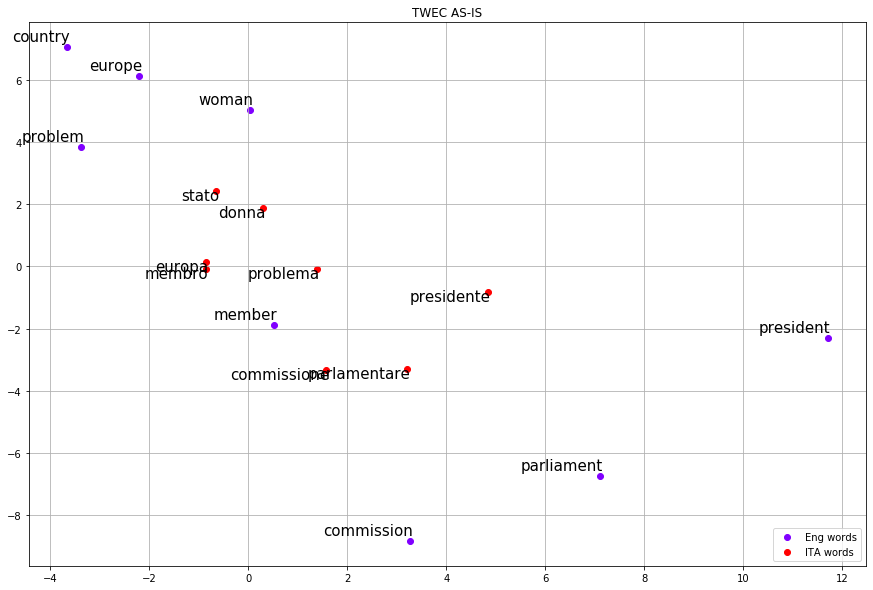

[[ 5.5586286  -0.20609504]
 [ 0.63235563 -1.8941524 ]
 [ 2.170588   -2.704647  ]
 [-0.87163085  1.5712154 ]
 [ 0.9229667   0.01070242]
 [-1.0111046   2.2852614 ]
 [-1.0796223   1.575573  ]
 [-0.9111503   2.2767415 ]]


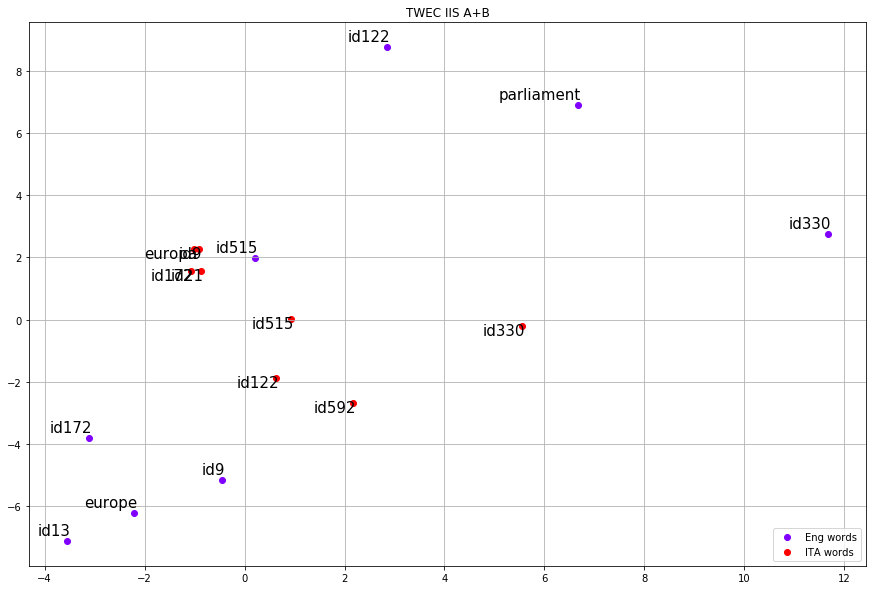

In [0]:
test_ita = [ 'presidente', 'commissione', 'parlamentare', 'stato', 'membro', 'europa', 'problema', 'donna']
test_eng = [ 'president', 'commission','parliament', 'country', 'member', 'europe', 'problem', 'woman']
test_eng_mapped,test_ita_mapped = substitute_mapping_test( test_eng,test_ita, maps)
test_ita = [ 'presidente', 'commissione', 'parlamentare', 'stato', 'membro', 'europa', 'problema', 'donna']
test_eng = [ 'president', 'commission','parliament', 'country', 'member', 'europe', 'problem', 'woman']

print(test_ita)
print(test_eng)
print(test_ita_mapped)
print(test_eng_mapped)

plot_("TWEC AS-IS", test_eng, slice_en, pca_en, test_ita,slice_ita, pca_ita)
plot_("TWEC IIS A+B", test_eng_mapped,slice_en_mapped, pca_en_mapped, test_ita_mapped,slice_ita_mapped, pca_ita_mapped)



In [0]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    print( model.wv.vocab[:20] )

    for word in model.wv.vocab[:20]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(slice_en)